In [3]:
#!pip install ipympl

In [4]:
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal import firwin
import matplotlib.patches as patches
from scipy.io import savemat
from tqdm import tqdm
from scipy.interpolate import CubicSpline

# Functions

In [5]:
def IQ_LUT(const):
    mapping_table_QAM16 = {
        (0,0,0,0) : -3-3j,
        (0,0,0,1) : -3-1j,
        (0,0,1,0) : -3+3j,
        (0,0,1,1) : -3+1j,
        (0,1,0,0) : -1-3j,
        (0,1,0,1) : -1-1j,
        (0,1,1,0) : -1+3j,
        (0,1,1,1) : -1+1j,
        (1,0,0,0) :  3-3j,
        (1,0,0,1) :  3-1j,
        (1,0,1,0) :  3+3j,
        (1,0,1,1) :  3+1j,
        (1,1,0,0) :  1-3j,
        (1,1,0,1) :  1-1j,
        (1,1,1,0) :  1+3j,
        (1,1,1,1) :  1+1j
    }
    demapping_table_QAM16 = {v : k for k, v in mapping_table_QAM16.items()}

    if const=='16QAM':
        mapping_table = mapping_table_QAM16
        demapping_table = demapping_table_QAM16

    return mapping_table, demapping_table

In [6]:
mapping_table, demapping_table = IQ_LUT('16QAM')

In [7]:
def SP(bits, rows, columns):
    # bits - signal to S/P
    # rows - num of subcarriers
    # columns - bits in IQ symbol

    return bits.reshape((rows, columns))

In [8]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

In [9]:
def OFDM_symbol(QAM_payload, K, N, Nfft):
    # QAM_payload - mapped data
    # Nfft - total amount of subcarriers
    # K - amount of data-subcarriers
    # N - total number of OFDM symbols transmitted

    symbols = np.zeros((Nfft,N), dtype=complex) # matrix [Nfft,N]
    data=QAM_payload.reshape((K,N))

    start = Nfft//2-K//2
    symbols[start:start+K,:] = data
    return symbols

In [10]:
def IDFT(OFDM_data,Nfft,N):
    OFDM_data2 = np.fft.ifftshift(OFDM_data,0)
    return np.fft.ifftn(OFDM_data2,[Nfft,N])

In [11]:
def power_set(signal, Sig_pow_dB):
    Sig_pow = 10**(Sig_pow_dB/10)
    power=np.mean(np.abs(signal)**2) # current mean power of the signal
    amp_factor = np.sqrt(Sig_pow/power)
    signal = amp_factor*signal
    return signal

In [12]:
def channel(signal,noise_dB):
    signal_power = np.mean(np.abs(signal)**2)
    sigma2=10**(noise_dB/10)
    SNRdB = 10*np.log10(signal_power/sigma2)
    # print('SNR for given noise and signal power: %.4f Signal power in dB: %.4f' % (SNRdB, 10*np.log10(signal_power)))

    # Generate noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*signal.shape)+1j*np.random.randn(*signal.shape))
    noise_power = 10*np.log10(np.mean(np.abs(noise)**2))
    print('Noise power in dB: %.2f' % (noise_power))

    return noise, noise + signal

In [13]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

In [14]:
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])

    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))

    # for each element in QAM, choose the index in constellation
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)

    # get back the real constellation point
    hardDecision = constellation[const_index]

    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

In [15]:
def PS(bits):
    return bits.reshape((-1,))

# OFDM generator

## Parameters setting

In [16]:
Fc1 = 20e3 # in kHz n25 band carrier frequency
Fc2 = 20e3 # in kHz n66 band carrier frequency

K = 64 # number of used OFDM subcarriers
df = 2*5*1e3/K # scs in kHz, 2*Occupied_bandwidth[Mhz]*1e3/Subcarrier_num
Nfft = int(2048*2)

B = df*int(Nfft/2) #  bandwidth in kHz
print("Current Bandwidth: in kHz", B)
print("Current Occupied Bandwidth: in kHz", df*int(K/2))
Fs = B         # sampling frequency
N = 1000           # number of OFDM symbols transmitted

### Power
Sig_pow_dB = 90 # signal power in dB
noise_dB = 50  # noise power

### Carrier arrangement
# allCarriers = np.arange(Nfft)  # indices of all subcarriers ([0, 1, ... Nfft-1])
# dataCarriers = np.arange(K)    # indices of all data-subcarriers ([0, 1, ... K-1])
mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = K*mu  # number of payload bits per OFDM symbol

Current Bandwidth: in kHz 320000.0
Current Occupied Bandwidth: in kHz 5000.0


In [17]:
##### Bits generation
np.random.seed(6)
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, N))
np.random.seed(65)
bits2 = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, N))

##### S/P
bits_SP = SP(bits, N*K, mu)
bits_SP2 = SP(bits2, N*K, mu)

##### Mapping bits into constellation points
QAM = Mapping(bits_SP)
QAM2 = Mapping(bits_SP2)

##### OFDM-symbol creation
OFDM_data = OFDM_symbol(QAM, K,N, Nfft)
OFDM_data2 = OFDM_symbol(QAM2, K,N, Nfft)

##### IDFT operation (freq->time)
OFDM_time = IDFT(OFDM_data,Nfft,N)
OFDM_time2 = IDFT(OFDM_data2,Nfft,N)

t = np.arange(0, Nfft/Fs, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/Nfft)  # the corresponding frequency samples
s = OFDM_time
s_2 = OFDM_time2

##### Freqs shift in baseband
s1 = (np.transpose(s)*np.exp(-1j*2*np.pi*Fc1*t)).T
s2 = (np.transpose(s_2)*np.exp(1j*2*np.pi*Fc2*t)).T

In [18]:
# Power setting
s_amp_1 = power_set(s1, Sig_pow_dB)*np.sqrt(K/Nfft)  # normalization for K-freqs
s_amp_2 = power_set(s2, Sig_pow_dB)*np.sqrt(K/Nfft)  # normalization for K-freqs

In [19]:
nperseg = 1024
noise, s_1_noised = channel(s_amp_1,noise_dB)
_, s_2_noised = channel(s_amp_2,noise_dB)

Noise power in dB: 50.00
Noise power in dB: 50.00


## Plot of the bandwith allocation

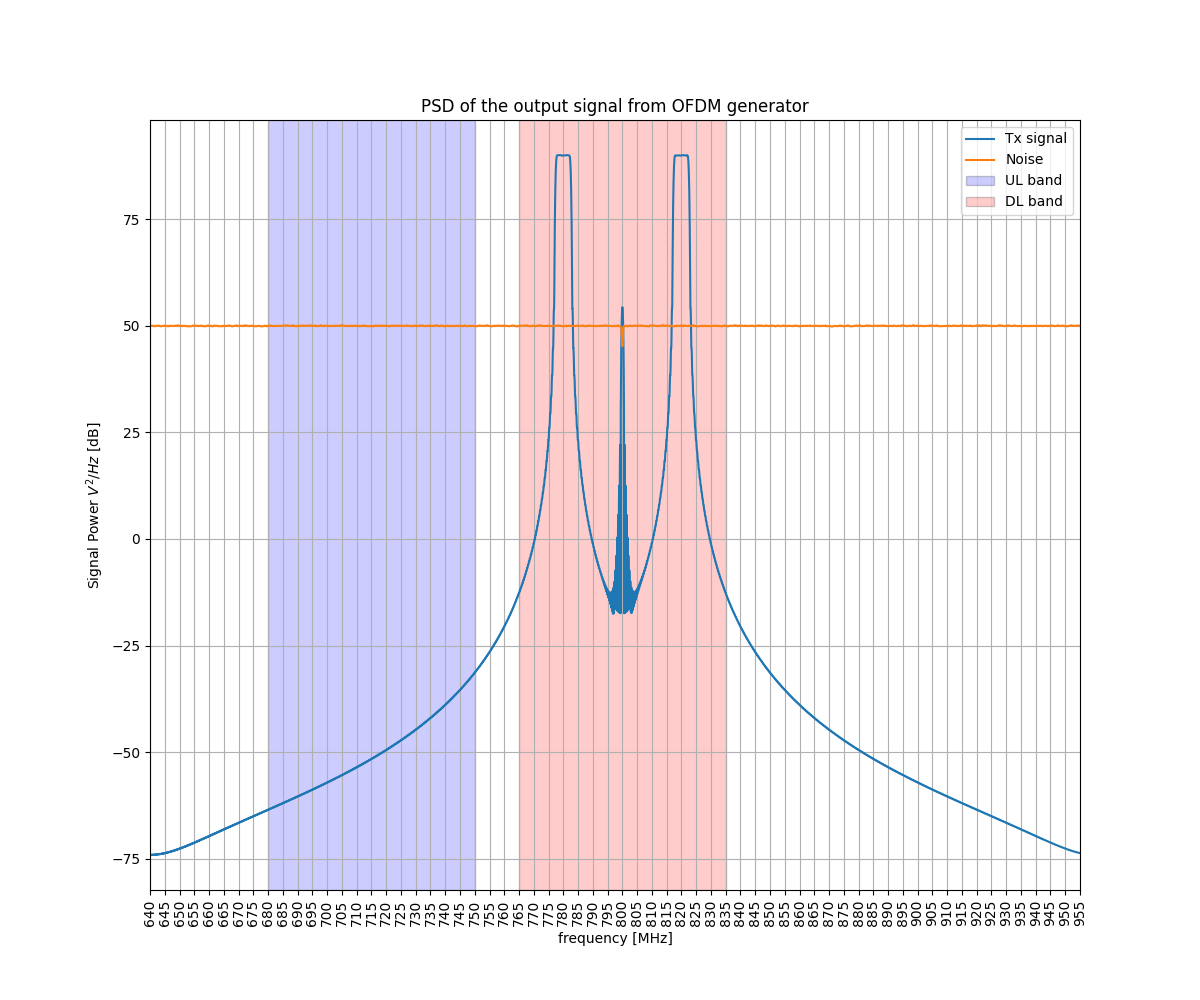

In [67]:
f, Pxx_spec = welch(np.transpose(s_amp_1+s_amp_2), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, noise_spec = welch(np.transpose(noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_rx_spec = welch(np.transpose(s_1_noised), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)

Pxx_spec = np.mean(Pxx_spec,0)
noise_spec = np.mean(noise_spec,0)
s_rx_spec = np.mean(s_rx_spec,0)

Pxx_dB=10*np.log10(np.abs(Pxx_spec)*Fs)
noise_spec_dB= 10*np.log10(np.abs(noise_spec)*Fs)
s_rx_spec_dB = 10*np.log10(np.abs(s_rx_spec)*Fs)

plt.figure(figsize=(12,10))
shift = 800e3 # in kHz
f_MHz = (f+shift) / 1e3

plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(Pxx_dB), label='Tx signal')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(noise_spec_dB), label='Noise')
#plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_rx_spec_dB), label='Rx signal', alpha=0.6)
plt.xlabel('frequency [MHz]')
plt.ylabel('Signal Power $V^2/Hz$ [dB]')
# plt.ylim(bottom=0)
plt.xlim(left=(-2*Fc1+shift)/1e3, right=(2*Fc2+shift)/1e3)

# Specify the UP-link bandwidth
bandwidth_up = 70 # in MHz
Fc_up = (Fc1+shift)/1e3-1.5*bandwidth_up # in MHz
up_band = patches.Rectangle((Fc_up - bandwidth_up / 2, plt.ylim()[0]),
                          bandwidth_up, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='blue',alpha = 0.2, label='UL band')
plt.gca().add_patch(up_band)

# Specify the DL-link bandwidth
bandwidth_dl = 70 # in MHz
Fc_dl = (shift)/1e3 # in MHz
dl_band = patches.Rectangle((Fc_dl - bandwidth_dl / 2, plt.ylim()[0]),
                          bandwidth_dl, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='red',alpha = 0.2, label='DL band')
plt.gca().add_patch(dl_band)

custom_bins = np.arange(np.min(f_MHz), np.max(f_MHz), 5)
plt.xticks(custom_bins, rotation='vertical')
plt.grid()
plt.legend()
plt.title("PSD of the output signal from OFDM generator")
plt.show()

# Tx antenna array

## Functions

In [21]:
def get_raw_pattern(angle_grid,type):
    """
    Initial patterns of the antenna elements
    """
    d2r = np.pi/180
    if type == "uniform":
        F = np.ones(len(angle_grid))
    elif type == "cos1":
        F = np.cos(0.5*angle_grid*d2r)**2
    elif type == "cos2":
        F = np.cos(angle_grid*d2r)**2
    elif type == "cos3":
        F = np.abs(np.cos(angle_grid*d2r))
    elif type == "cos4":
        F = np.cos(angle_grid*d2r)**32
    else:
        None

    # pattern normalization
    # F = F / np.sqrt(np.sum(np.abs(F)**2))
    return F

In [22]:
def plot_pattern_polar_lin(phi, r, title):
    plt.title(title)
    plt.polar(phi,r)

In [23]:
def plot_pattern_polar_dB(phi, r, title):
    plt.title(title)
    plt.polar(phi,10*np.log10(r))

## Tx antenna parameters

In [24]:
angles = np.arange(0,361,1)   # array of degrees
d2r=np.pi/180

AOD_user = 24                     # angle of departure in degrees - USER location
AOD_user_rad = AOD_user * d2r

Ntx = 4                       # number of Tx antenna elements
c=3e8                         #speed of light
lambd1=(Fc1+shift)*1e3/c
lambd2=(-Fc2+shift)*1e3/c
d = lambd1/4                      # antenna interelement spacing

## Tx antenna response

In [25]:
F_tx = get_raw_pattern(angles,"cos3")

def get_channel(AOD,lamb):
  m_tx = F_tx[AOD]                    # element radiation pattern
  M_tx=np.tile(m_tx,[Ntx,1])          # elements radiation pattern
  A = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(d2r*AOD)/lamb)  # basic array response
  A=A.reshape(-1,1)

  AR = A * M_tx # array response = basic array response * element radiation pattern
  return AR

In [26]:
H1 = get_channel(AOD_user,lambd1)
H2 = get_channel(AOD_user,lambd2)

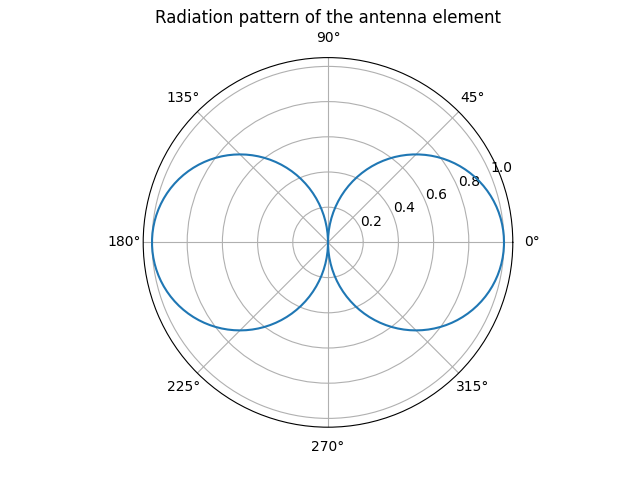

In [27]:
plt.figure()
plt.subplot(projection = 'polar')
plot_pattern_polar_lin(angles*d2r,F_tx,"Radiation pattern of the antenna element")
plt.show()

## Tx Beamforming

In [28]:
s_1_noised.shape

(4096, 1000)

In [29]:
signal_1 = s_amp_1
signal_1 = signal_1.reshape(-1,1).T

signal_2 = s_amp_2
signal_2 = signal_2.reshape(-1,1).T


# matrix multiply
tx_signal_1 = np.kron(H1,signal_1) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension
tx_signal_2 = np.kron(H1,signal_2) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension
# tx_signal_1 = np.reshape(tx_signal,(Ntx,Nfft,N))

In [30]:
signal_1.shape, tx_signal_1.shape

((1, 4096000), (4, 4096000))

### Precode our signal in case of MISO

In [31]:
w_1 = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(AOD_user_rad)/lambd1) # Conventional, aka delay-and-sum, beamformer
w_1=w_1.reshape(-1,1)/np.linalg.norm(w_1) # reshape and norm our precoder
tx_precoded_1 = w_1.conj().T @ tx_signal_1 # apply our weights. remember r is 3x10000

w_2 = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(AOD_user_rad)/lambd2) # Conventional, aka delay-and-sum, beamformer
w_2=w_2.reshape(-1,1)/np.linalg.norm(w_2) # reshape and norm our precoder
tx_precoded_2 = w_2.conj().T @ tx_signal_2 # apply our weights. remember r is 3x10000

### Plot radiation pattern of the precoded signal, spectrum of the precoded signal

In [32]:
results = []
for angle in angles:
    w = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(angle*d2r)) # Conventional, aka delay-and-sum, beamformer
    w=w.reshape(-1,1)/np.linalg.norm(w) # reshape and norm our precoder
    r_weighted = w.conj().T @ tx_signal_1 # apply our weights. remember r is 3x10000
    results.append((np.mean(np.abs(r_weighted)**2))) # power in signal, in dB so its easier to see small and large lobes at the same time

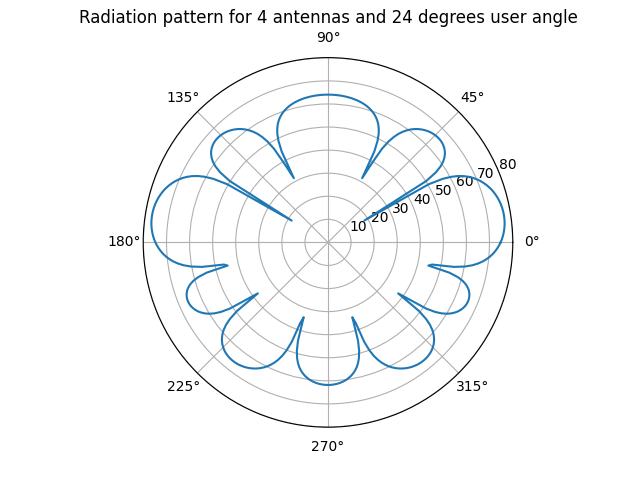

In [33]:
plt.figure()
plt.subplot(projection = 'polar')
plot_pattern_polar_dB(angles*d2r,np.array(results),"Radiation pattern for "+str(Ntx)
                        +" antennas and "+str(AOD_user) + " degrees user angle")
plt.show()

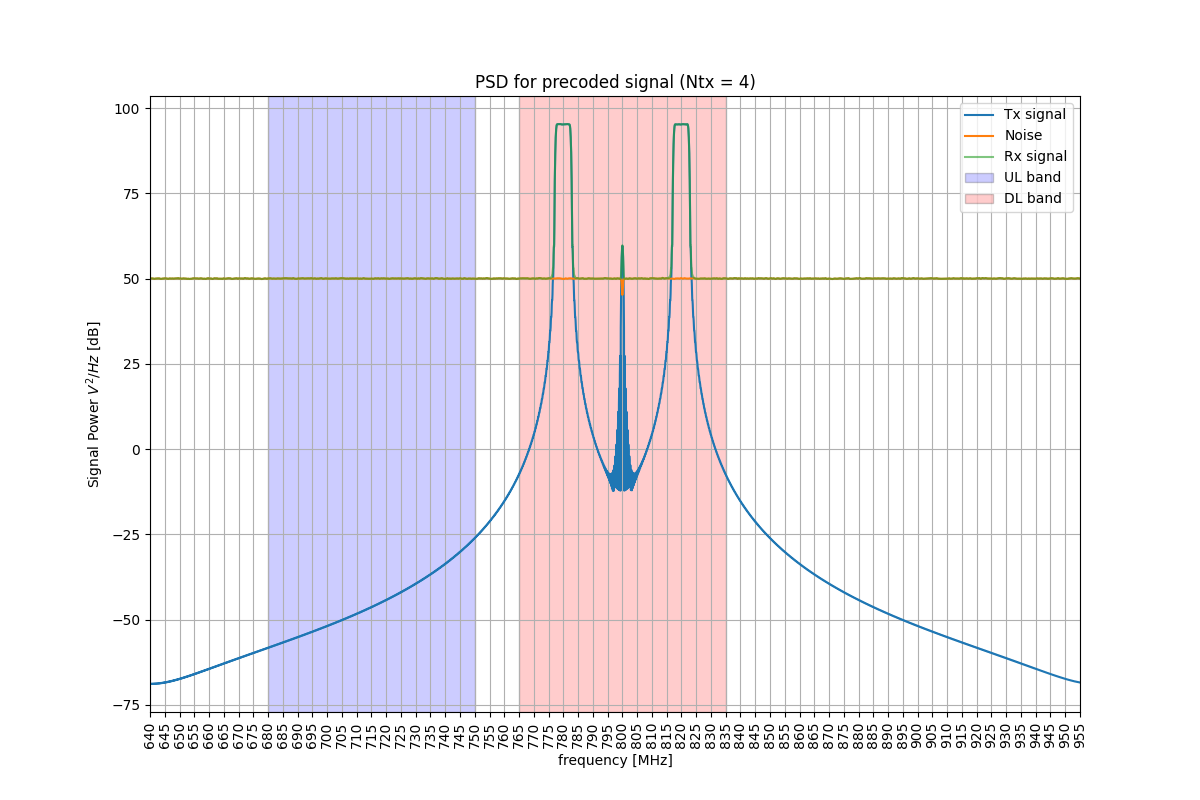

In [34]:
tx_precoded_11 = np.reshape(tx_precoded_1,(Nfft,N))
tx_precoded_22 = np.reshape(tx_precoded_2,(Nfft,N))

f, Pxx_spec = welch(np.transpose(tx_precoded_11+tx_precoded_22), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, noise_spec = welch(np.transpose(noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_rx_spec = welch(np.transpose(tx_precoded_11+tx_precoded_22+noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)

Pxx_spec = np.mean(Pxx_spec,0)
noise_spec = np.mean(noise_spec,0)
s_rx_spec = np.mean(s_rx_spec,0)

Pxx_dB=10*np.log10(np.abs(Pxx_spec)*Fs)
noise_spec_dB= 10*np.log10(np.abs(noise_spec)*Fs)
s_rx_spec_dB = 10*np.log10(np.abs(s_rx_spec)*Fs)

plt.figure(figsize=(12,8))
shift = 800e3 # in kHz
f_MHz = (f+shift) / 1e3

plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(Pxx_dB), label='Tx signal')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(noise_spec_dB), label='Noise')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_rx_spec_dB), label='Rx signal', alpha=0.6)
plt.xlabel('frequency [MHz]')
plt.ylabel('Signal Power $V^2/Hz$ [dB]')
# plt.ylim(bottom=0)
plt.xlim(left=(-2*Fc1+shift)/1e3, right=(2*Fc2+shift)/1e3)

# Specify the UP-link bandwidth
bandwidth_up = 70 # in MHz
Fc_up = (Fc1+shift)/1e3-1.5*bandwidth_up # in MHz
up_band = patches.Rectangle((Fc_up - bandwidth_up / 2, plt.ylim()[0]),
                          bandwidth_up, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='blue',alpha = 0.2, label='UL band')
plt.gca().add_patch(up_band)

# Specify the DL-link bandwidth
bandwidth_dl = 70 # in MHz
Fc_dl = (shift)/1e3 # in MHz
dl_band = patches.Rectangle((Fc_dl - bandwidth_dl / 2, plt.ylim()[0]),
                          bandwidth_dl, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='red',alpha = 0.2, label='DL band')
plt.gca().add_patch(dl_band)

custom_bins = np.arange(np.min(f_MHz), np.max(f_MHz), 5)
plt.xticks(custom_bins, rotation='vertical')
plt.grid()
plt.legend()
plt.title("PSD for precoded signal (Ntx = "+str(Ntx)+")")
plt.show()

# ePIM source configuration

## Input ePIM signal generation

In [35]:
F_tx = get_raw_pattern(angles,"cos3")

def get_ePIM_channel(AOD,lamb,d_PIM):
  m_tx = F_tx[AOD]                    # element radiation pattern
  M_tx=np.tile(m_tx,[Ntx,1])          # elements radiation pattern
  atten=1/np.sqrt(4*np.pi*(-d * (np.arange(1,Ntx))*np.cos(d2r*(AOD+90)) + ((np.arange(1,Ntx))*d*np.sin(d2r*(AOD+90)))**2/(2*d_PIM))**2)
  at=np.array([1/np.sqrt(4*np.pi*d_PIM)])
  atten=np.append(at,atten)
  A = atten*np.exp(-2j * np.pi/lamb * (-d * np.arange(Ntx)*np.cos(d2r*(AOD+90)) + (np.arange(Ntx)*d*np.sin(d2r*(AOD+90)))**2/(2*d_PIM)))  # basic array response
  A=A.reshape(-1,1)

  AR = A * M_tx # array response = basic array response * element radiation pattern
  return AR

In [36]:
AOD_PIM = 20                     # angle of departure in degrees - ePIM location
AOD_PIM_rad = AOD_PIM * d2r
d_PIM = 35 / 100 # distance towards ePIM

lambd3 = (Fc_up)*1e6/c

In [37]:
H1 = get_ePIM_channel(AOD_PIM,lambd1, d_PIM)
H2 = get_ePIM_channel(AOD_PIM,lambd2, d_PIM)

In [38]:
H1, H2

(array([[ 0.44807103+0.j        ],
        [-0.10149492-0.30578869j],
        [ 0.09187065-0.01933149j],
        [ 0.01469545-0.0416458j ]]),
 array([[ 0.44807103+0.j        ],
        [-0.1306293 -0.29452322j],
        [ 0.08051198-0.04828813j],
        [-0.01590229-0.04120007j]]))

In [39]:
signal_PIM_1 = s_amp_1
signal_PIM_1 = signal_PIM_1.reshape(-1,1).T

signal_PIM_2 = s_amp_2
signal_PIM_2 = signal_PIM_2.reshape(-1,1).T

# matrix multiply
tx_signal_PIM_1 = np.kron(H1,signal_PIM_1) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension
tx_signal_PIM_2 = np.kron(H2,signal_PIM_2) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension
# tx_signal = np.reshape(tx_signal,(Ntx,Nfft,N))

In [40]:
w = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(d2r*AOD_user)) # Apply same precoder as for USER
w=w.reshape(-1,1)/np.linalg.norm(w)
tx_precoded_PIM_1 = w.conj().T @ tx_signal_PIM_1 # apply our weights for signal towards ePIM
tx_precoded_PIM_2 = w.conj().T @ tx_signal_PIM_2 # apply our weights for signal towards ePIM

In [41]:
tx_precoded_PIM=tx_precoded_PIM_1+tx_precoded_PIM_2
tx_precoded_PIM = np.reshape(np.squeeze(tx_precoded_PIM),(Nfft,N))

## Output ePIM signal generation

In [42]:
tx_PIM_out = tx_precoded_PIM*np.abs(tx_precoded_PIM)**2
#tx_PIM_out = s_amp*np.abs(s_amp)**2

In [43]:
alpha = 0.55 # attenuation of the ePIM signal

In [44]:
Sig_pow=np.mean(np.abs(s_amp_1+s_amp_2)**2) # current mean power of the Tx signal
power=np.mean(np.abs(tx_PIM_out)**2) # current mean power of the PIM
amp_factor = np.sqrt(Sig_pow/power)
tx_PIM_out = alpha*amp_factor*tx_PIM_out

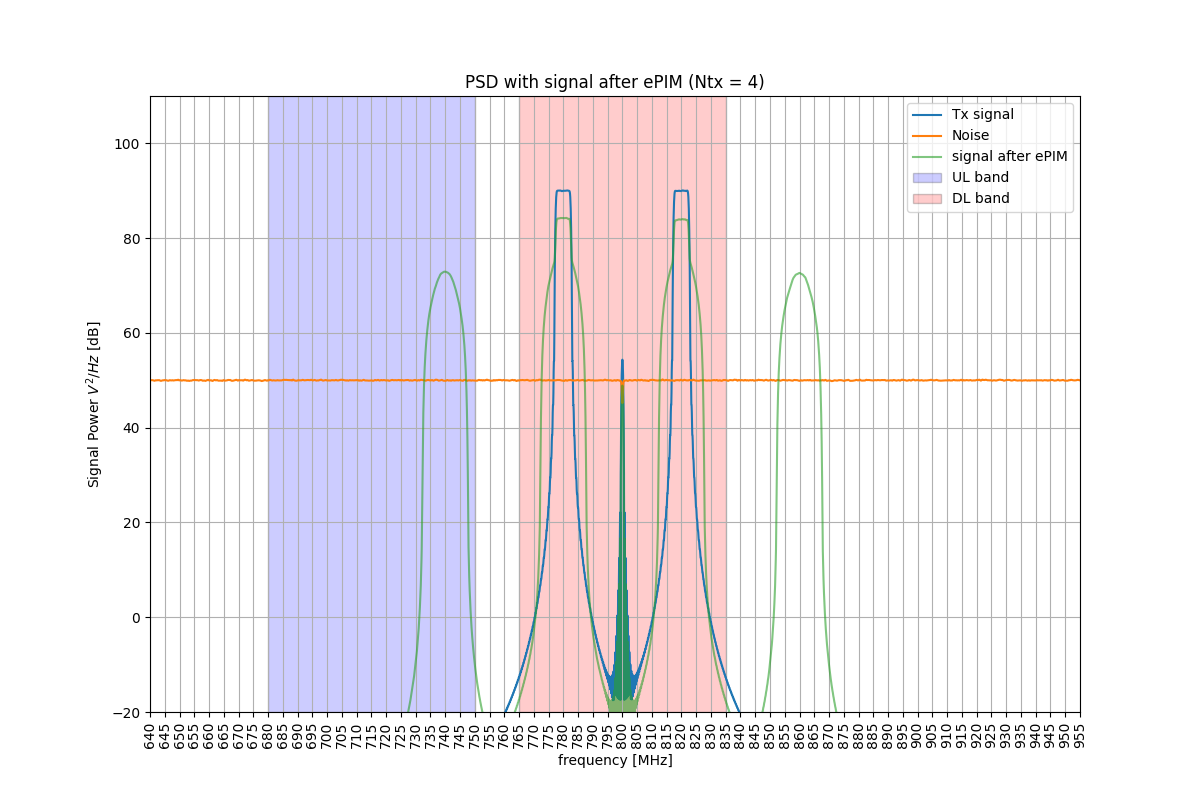

In [45]:
f, Pxx_spec = welch(np.transpose(s_amp_1+s_amp_2), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, noise_spec = welch(np.transpose(noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_PIM = welch(np.transpose(tx_PIM_out), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)

Pxx_spec = np.mean(Pxx_spec,0)
noise_spec = np.mean(noise_spec,0)
s_PIM_spec = np.mean(s_PIM,0)

Pxx_dB=10*np.log10(np.abs(Pxx_spec)*Fs)
noise_spec_dB= 10*np.log10(np.abs(noise_spec)*Fs)
s_PIM_dB = 10*np.log10(np.abs(s_PIM_spec)*Fs)

plt.figure(figsize=(12,8))
shift = 800e3 # in kHz
f_MHz = (f+shift) / 1e3

plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(Pxx_dB), label='Tx signal')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(noise_spec_dB), label='Noise')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_PIM_dB), label='signal after ePIM', alpha=0.6)

plt.xlabel('frequency [MHz]')
plt.ylabel('Signal Power $V^2/Hz$ [dB]')
plt.ylim(bottom=-20, top=110)
plt.xlim(left=(-5*Fc1+shift)/1e3, right=(5*Fc2+shift)/1e3)

# Specify the UP-link bandwidth
bandwidth_up = 70 # in MHz
Fc_up = (Fc1+shift)/1e3-1.5*bandwidth_up # in MHz
up_band = patches.Rectangle((Fc_up - bandwidth_up / 2, plt.ylim()[0]),
                          bandwidth_up, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='blue',alpha = 0.2, label='UL band')
plt.gca().add_patch(up_band)

# Specify the DL-link bandwidth
bandwidth_dl = 70 # in MHz
Fc_dl = (shift)/1e3 # in MHz
dl_band = patches.Rectangle((Fc_dl - bandwidth_dl / 2, plt.ylim()[0]),
                          bandwidth_dl, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='red',alpha = 0.2, label='DL band')
plt.gca().add_patch(dl_band)

custom_bins = np.arange(np.min(f_MHz), np.max(f_MHz), 5)
plt.xticks(custom_bins, rotation='vertical')
plt.grid()
plt.legend()
plt.title("PSD with signal after ePIM (Ntx = "+str(Ntx)+")")
plt.show()

## ePIM signal back propagation

In [46]:
H3 = get_ePIM_channel(AOD_PIM,lambd3, d_PIM)

In [47]:
signal_PIM_bp = tx_PIM_out
signal_PIM_bp = signal_PIM_bp.reshape(-1,1).T

# matrix multiply
sig_PIM = np.kron(H3,signal_PIM_bp) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension

In [48]:
sig_PIM.shape

(4, 4096000)

In [49]:
RX_sig_PIM = np.reshape(sig_PIM,(Ntx,Nfft,N))

In [50]:
# Receiving ePIM in a certain channel:
rx_PIM=np.squeeze(RX_sig_PIM[0,:,:])+noise

In [51]:
# Filter design
lowcut = int(Fc_up - bandwidth_up / 2)
highcut = int(Fc_up + bandwidth_up / 2)

filter_f=f_MHz.copy()

for i in range(len(filter_f)):
  if (filter_f[i]<lowcut) | (filter_f[i]>highcut):
    filter_f[i]=0
  else:
    filter_f[i]=1

## Plot received ePIM signal

### Plot power by channel

In [52]:
RX_sig_PIM_mean = np.squeeze(np.mean(RX_sig_PIM,2))
# RX_sig_PIM_mean = np.squeeze(np.squeeze(RX_sig_PIM[:,:,5]))
print(RX_sig_PIM_mean.shape)

print(int(np.mean(np.abs(RX_sig_PIM_mean)**2))/Ntx)

(4, 4096)
185.75


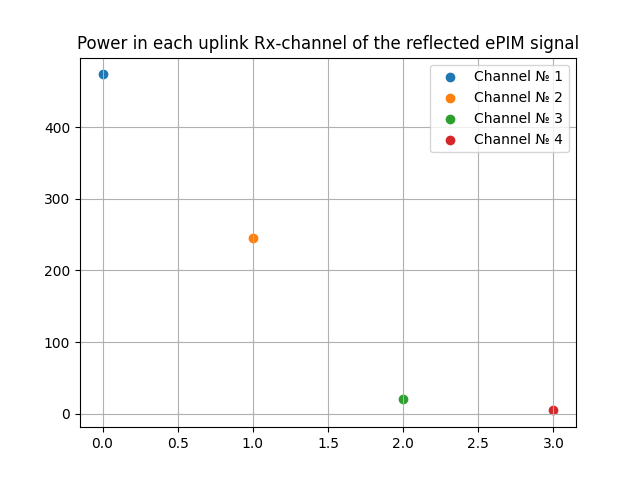

In [53]:
plt.figure()
for i in range(Ntx):
  namelabel = "Channel № " + str(i+1)
  plt.scatter(i,(np.mean(np.abs(RX_sig_PIM_mean[i,:])**2)/Ntx), label=namelabel)
plt.legend()
plt.grid()
plt.title("Power in each uplink Rx-channel of the reflected ePIM signal")
plt.show()

### Plot PSD with received PIM signal

In [54]:
# FFT=np.fft.fftn(s_amp,axes=(0,))
# FFT=np.mean(FFT,1)

# plt.figure()
# plt.plot(np.fft.fftshift(f_MHz),10 * np.log10(np.fft.fftshift(np.abs(FFT))**2))
# plt.show()
# #plt.close('all')

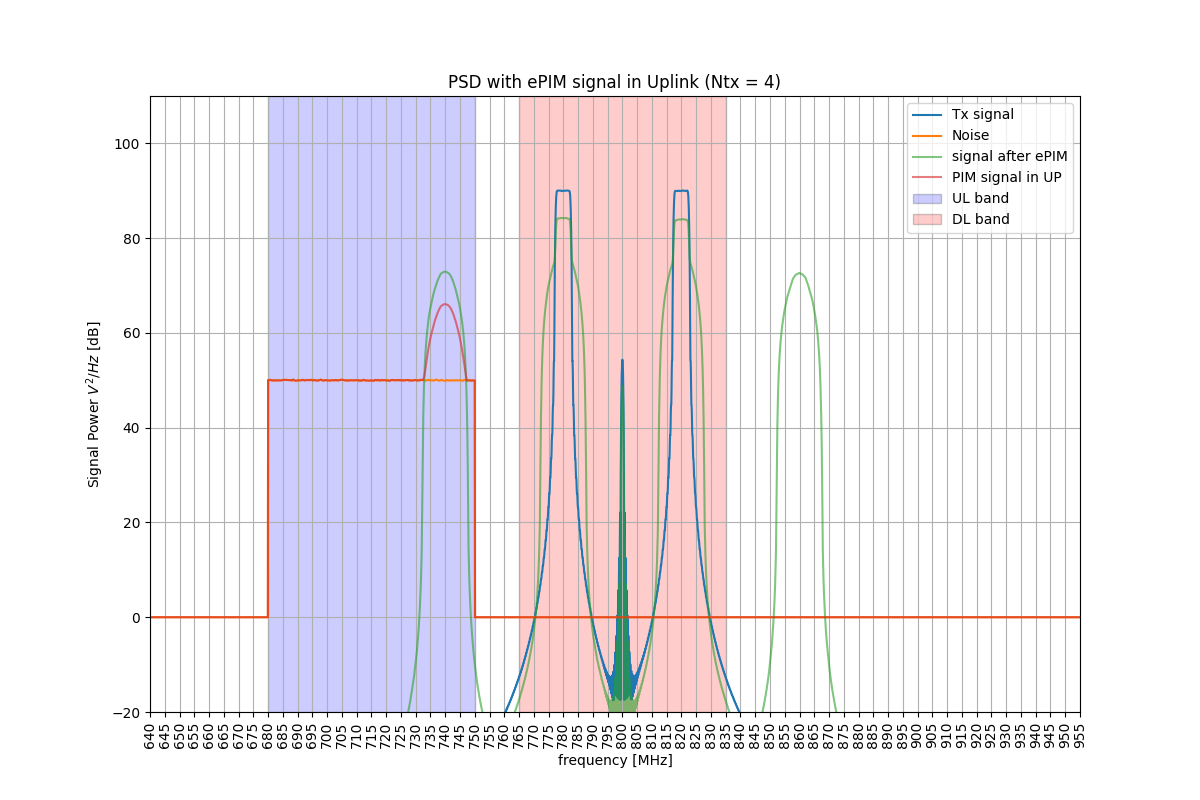

In [55]:
f, Pxx_spec = welch(np.transpose(s_amp_1+s_amp_2), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, noise_spec = welch(np.transpose(noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_PIM = welch(np.transpose(tx_PIM_out), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_rx_PIM = welch(np.transpose(rx_PIM), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)


Pxx_spec = np.mean(Pxx_spec,0)
noise_spec = np.mean(noise_spec,0)
s_PIM_spec = np.mean(s_PIM,0)
s_rx_PIM_spec = np.mean(s_rx_PIM,0)


Pxx_dB=10*np.log10(np.abs(Pxx_spec)*Fs)
noise_spec_dB= 10*np.log10(np.abs(noise_spec)*Fs)
s_PIM_dB = 10*np.log10(np.abs(s_PIM_spec)*Fs)
s_rx_PIM_dB = 10*np.log10(np.abs(s_rx_PIM_spec)*Fs)

## Applying filter in UP-link
s_rx_PIM_dB=s_rx_PIM_dB*filter_f
noise_spec_dB = noise_spec_dB*filter_f

plt.figure(figsize=(12,8))
shift = 800e3 # in kHz
f_MHz = (f+shift) / 1e3

plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(Pxx_dB), label='Tx signal')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(noise_spec_dB), label='Noise')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_PIM_dB), label='signal after ePIM', alpha=0.6)
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_rx_PIM_dB), label='PIM signal in UP', alpha=0.6)
plt.xlabel('frequency [MHz]')
plt.ylabel('Signal Power $V^2/Hz$ [dB]')
plt.ylim(bottom=-20, top=110)
plt.xlim(left=(-5*Fc1+shift)/1e3, right=(5*Fc2+shift)/1e3)

# Specify the UP-link bandwidth
bandwidth_up = 70 # in MHz
Fc_up = (Fc1+shift)/1e3-1.5*bandwidth_up # in MHz
up_band = patches.Rectangle((Fc_up - bandwidth_up / 2, plt.ylim()[0]),
                          bandwidth_up, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='blue',alpha = 0.2, label='UL band')
plt.gca().add_patch(up_band)

# Specify the DL-link bandwidth
bandwidth_dl = 70 # in MHz
Fc_dl = (shift)/1e3 # in MHz
dl_band = patches.Rectangle((Fc_dl - bandwidth_dl / 2, plt.ylim()[0]),
                          bandwidth_dl, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='red',alpha = 0.2, label='DL band')
plt.gca().add_patch(dl_band)

custom_bins = np.arange(np.min(f_MHz), np.max(f_MHz), 5)
plt.xticks(custom_bins, rotation='vertical')
plt.grid()
plt.legend()
plt.title("PSD with ePIM signal in Uplink (Ntx = "+str(Ntx)+")")
plt.show()

# Calibration: locating ePIM

In [56]:
# Pilot signal generation
# Ntx = 16
sample_rate = 1e6
N_samples = 10000 # number of samples to simulate

# Create a tone to act as the pilot signal
t = np.arange(N_samples)/sample_rate # time vector
f_tone = 820e6
lambd0=f_tone/c
tx_pilot = np.exp(2j * np.pi* f_tone * t)
tx_pilot=tx_pilot.reshape(1,-1)

In [57]:
def Precode(signal,AOD_c,lamb):
  w = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(d2r*AOD_c)/lamb) # Conventional, aka delay-and-sum, beamformer
  w=w.reshape(-1,1)/np.linalg.norm(w) # reshape and norm our precoder
  signal_precoded = w.conj().T @ signal # apply our weights. remember r is 3x10000
  return signal_precoded

## ePIM source configuration

In [58]:
AOD_PIM_c = 52                     # angle of departure in degrees - ePIM location
AOD_PIM_rad_c = AOD_PIM * d2r

H_PIM = get_channel(AOD_PIM_c,lambd0)       # channel towards ePIM source

## Main loop

In [59]:
angles_calib=np.array(np.linspace(-90, 90, num=35))
power_pilot = np.zeros(angles_calib.shape)
k=0
for AOD_angle in angles_calib:
  tx_pilot_ANT = np.kron(H_PIM,tx_pilot)           # signal in channel towards ePIM
  pilot_precoded = Precode(tx_pilot_ANT,AOD_angle,lambd0) # precoded TX signal towards AOD_angle out

  pilot_PIM_out = pilot_precoded*np.abs(pilot_precoded)**2 # ePIM out

  pilot_PIM_out = pilot_PIM_out.reshape(1,-1)
  rx_pilot_PIM = np.kron(H_PIM,pilot_PIM_out)     # rx ePIM on BS

  power_pilot[k]=(np.mean(np.abs(rx_pilot_PIM)**2))/Ntx**2
  k=k+1

xnew = np.linspace(-90, 90, num=181)
spl = CubicSpline(angles_calib, power_pilot)
ynew=spl(xnew)

print("ePIM located at ", xnew[np.argmax(ynew)])

ePIM located at  52.0


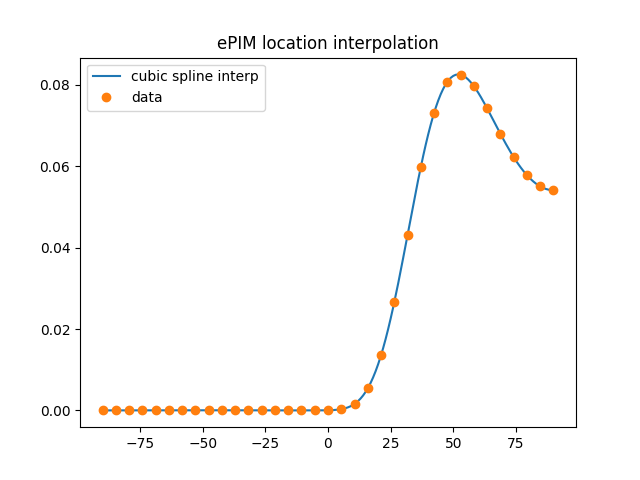

In [60]:
#ynew = np.interp(xnew, angles_calib, power_pilot) # linear interp
plt.figure()
plt.plot(xnew, ynew, '-', label='cubic spline interp')
plt.plot(angles_calib, power_pilot, 'o', label='data')
plt.legend(loc='best')
plt.title("ePIM location interpolation")
plt.show()

## Estimating error of founded angle

In [61]:
all_angles = np.array(np.linspace(-85, 85, num=171),dtype=int)
all_errors = np.zeros(all_angles.shape)
all_errors_lin = np.zeros(all_angles.shape)

In [62]:
p=0
amount = 25  # number of calibration rays
angles_calib=np.array(np.linspace(-90, 90, num=amount))
power_pilot = np.zeros(angles_calib.shape)

for angle in tqdm(all_angles):
  AOD_PIM_c = angle                 # angle of departure in degrees - ePIM location
  AOD_PIM_rad_c = AOD_PIM * d2r

  H_PIM = get_channel(AOD_PIM_c,lambd0)   # channel towards ePIM source
  k=0
  for AOD_angle in angles_calib:
    tx_pilot_ANT = np.kron(H_PIM,tx_pilot)           # signal in channel towards ePIM
    pilot_precoded = Precode(tx_pilot_ANT,AOD_angle,lambd0) # precoded TX signal towards AOD_angle out

    pilot_PIM_out = pilot_precoded*np.abs(pilot_precoded)**2 # ePIM out

    pilot_PIM_out = pilot_PIM_out.reshape(1,-1)
    rx_pilot_PIM = np.kron(H_PIM,pilot_PIM_out)     # rx ePIM on BS

    power_pilot[k]=(np.mean(np.abs(rx_pilot_PIM)**2))/Ntx**2
    k=k+1

  xnew = np.linspace(-90, 90, num=181)
  spl = CubicSpline(angles_calib, power_pilot)
  ynew_linear = np.interp(xnew, angles_calib, power_pilot)
  ynew=spl(xnew)

  # print("ePIM located at ", xnew[np.argmax(ynew)])
  all_errors[p]= np.abs(AOD_PIM_c-xnew[np.argmax(ynew)])
  all_errors_lin[p]= np.abs(AOD_PIM_c-xnew[np.argmax(ynew_linear)])
  p=p+1

print("\n linear MSE: ",np.mean(all_errors_lin**2)**(1/2))
print("\n spline MSE: ",np.mean(all_errors**2)**(1/2))

100%|██████████| 171/171 [00:03<00:00, 44.49it/s]


 linear MSE:  2.0290290940071523

 spline MSE:  0.5722633835193014


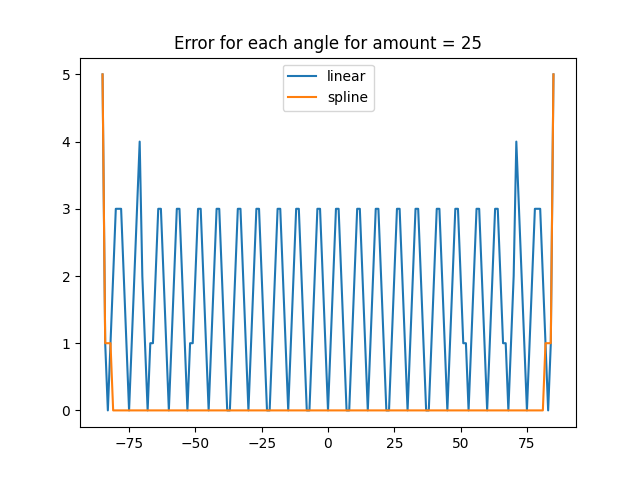

In [63]:
plt.figure()
plt.plot(all_angles, all_errors_lin, '-',label="linear")
plt.plot(all_angles, all_errors, '-',label="spline")
plt.title('Error for each angle for amount = '+ str(amount))
plt.legend(loc="best")
plt.show()

## Finding optimal amount of interp points for each angle

In [64]:
all_angles = np.array(np.linspace(-90, 90, num=181),dtype=int)
all_amounts = np.zeros(all_angles.shape)
all_angles

array([-90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78,
       -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65,
       -64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53, -52,
       -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39,
       -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26,
       -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13,
       -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  9

In [65]:
p=0
for angle in tqdm(all_angles):
  AOD_PIM_c = angle                 # angle of departure in degrees - ePIM location
  AOD_PIM_rad_c = AOD_PIM * d2r

  H_PIM = get_channel(AOD_PIM_c,lambd0)  # channel towards ePIM source

  error = 1
  amount= 4

  while error>0.01:
    k=0
    angles_calib=np.array(np.linspace(-90, 90, num=amount))
    power_pilot = np.zeros(angles_calib.shape)

    for AOD_angle in angles_calib:
      tx_pilot_ANT = np.kron(H_PIM,tx_pilot)           # signal in channel towards ePIM
      pilot_precoded = Precode(tx_pilot_ANT,AOD_angle,lambd0) # precoded TX signal towards AOD_angle out

      pilot_PIM_out = pilot_precoded*np.abs(pilot_precoded)**2 # ePIM out

      pilot_PIM_out = pilot_PIM_out.reshape(1,-1)
      rx_pilot_PIM = np.kron(H_PIM,pilot_PIM_out)     # rx ePIM on BS

      power_pilot[k]=(np.mean(np.abs(rx_pilot_PIM)**2))/Ntx**2
      k=k+1

    xnew = np.linspace(-90, 90, num=181)
    spl = CubicSpline(angles_calib, power_pilot)
    ynew=spl(xnew)

    # print("ePIM located at ", xnew[np.argmax(ynew)])
    error = np.abs(AOD_PIM_c-xnew[np.argmax(ynew)])
    if error > 0.01:
      amount=amount + 1

  all_amounts[p]=amount
  p=p+1

100%|██████████| 181/181 [00:39<00:00,  4.57it/s]


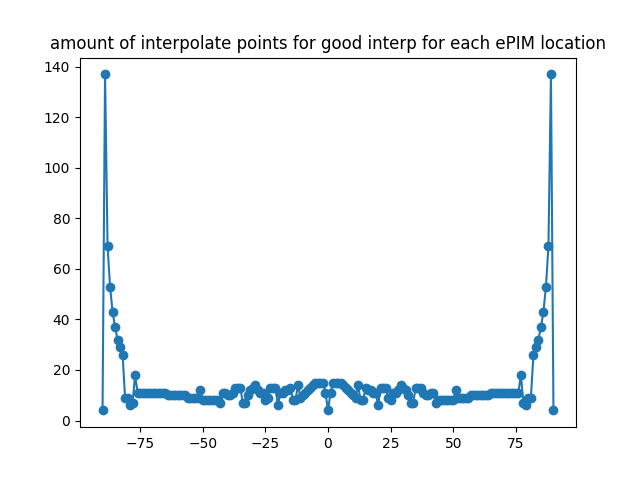

In [66]:
plt.figure()
plt.plot(all_angles, all_amounts, '-o')
plt.title('amount of interpolate points for good interp for each ePIM location')
plt.show()